In [11]:
from influxdb import InfluxDBClient
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import joblib


In [12]:
influx_client = InfluxDBClient(host='localhost', port=8086, database='iot_s1')

query = 'SELECT * FROM "environment"'
result = influx_client.query(query)

points = list(result.get_points())
df = pd.DataFrame(points)

print(df.head)

<bound method NDFrame.head of                       time     device_id  humidity  temperature
0     2024-05-07T04:45:12Z          None      65.0         25.3
1     2024-05-07T04:45:42Z          None      64.0         25.8
2     2024-05-07T04:46:12Z          None      64.0         26.2
3     2024-05-07T04:46:42Z          None      63.0         26.2
4     2024-05-07T04:47:12Z          None      63.0         26.2
...                    ...           ...       ...          ...
3043  2024-05-22T16:29:46Z  DHT11-SC-E01      40.0         28.5
3044  2024-05-22T16:30:16Z  DHT11-SC-E01      40.0         28.5
3045  2024-05-22T16:30:46Z  DHT11-SC-E01      40.0         28.5
3046  2024-05-22T16:31:16Z  DHT11-SC-E01      40.0         28.5
3047  2024-05-22T16:31:46Z  DHT11-SC-E01      40.0         28.5

[3048 rows x 4 columns]>


In [13]:
df.sort_values('time', inplace=True)

N = 3

features = []
targets = []

for i in range(N, len(df)):
    features.append(df[['temperature', 'humidity']].iloc[i-N:i].values)
    targets.append(df['temperature'].iloc[i])

features = np.array(features)
targets = np.array(targets)

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

scaler = MinMaxScaler(feature_range=(0, 1))
n_samples, n_timesteps, n_features = X_train.shape

X_train_flattened = X_train.reshape(n_samples * n_timesteps, n_features)
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_train_scaled = X_train_scaled.reshape(n_samples, n_timesteps, n_features)

X_test_flattened = X_test.reshape(X_test.shape[0] * n_timesteps, n_features)
X_test_scaled = scaler.transform(X_test_flattened)
X_test_scaled = X_test_scaled.reshape(X_test.shape[0], n_timesteps, n_features)

joblib.dump(scaler, 'scaler_sq.pkl')

model = Sequential([
    LSTM(200, return_sequences=True, input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    LSTM(200, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=0.00001)

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_scaled, y_train, epochs=200, batch_size=16, validation_data=(X_test_scaled, y_test))

model.save('LSTM.h5')

Epoch 1/200


/home/maith/.local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 312.1682 - val_loss: 0.5146
Epoch 2/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 1.5103 - val_loss: 0.5067
Epoch 3/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 1.5729 - val_loss: 0.4702
Epoch 4/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1.5095 - val_loss: 0.4391
Epoch 5/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1.4049 - val_loss: 0.4148
Epoch 6/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1.5037 - val_loss: 0.3215
Epoch 7/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1.2852 - val_loss: 0.2315
Epoch 8/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 1.2322 - val_loss: 0.1228
Epoch 9/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 1.1856 - val_loss: 0.1097
Epoch 10/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 1.1467 - val_loss: 0.1059
Epoch 11/200
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 1.1914 - val_loss: 0.1167
Epoch 12/200
153/153 ━━━━━━━━━━━━━━━━━━━

In [14]:
# Evaluation
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

model = load_model('LSTM.h5')

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absulote Error: {mae}')
print(f'R^2 Score: {r2}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Mean Squared Error: 0.07473795763305022
Root Mean Squared Error: 0.2733824384137544
Mean Absulote Error: 0.1995756954199376
R^2 Score: 0.8894462812820211


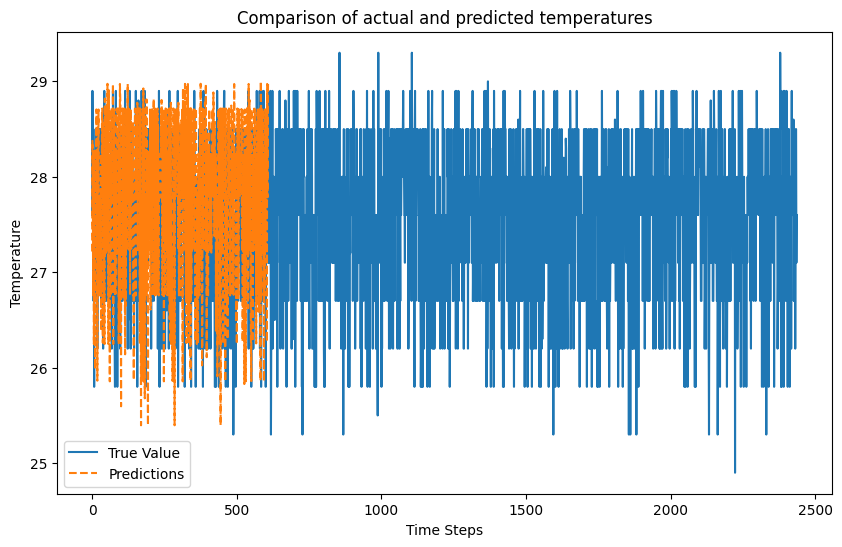

In [15]:
# plotting the model
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_train, label='True Value')
plt.plot(y_pred, label='Predictions', linestyle='--')
plt.title('Comparison of actual and predicted temperatures')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()